# 파이토치 MNIST 모델

<br>

<br>

## modules import 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from matplotlib import pyplot as plt

import numpy as np


<br>

<br>

## 전처리 설정
- `transform.Compose`

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5, ))])

<br>

<br>

## GPU 설정 후 학습
- 설정 후, 모델과 데이터에 `to`로 GPU를 사용 가능한 형태로 변환 해줘야 한다.

- `.cuda()` 로도 가능

In [ ]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cuda


<br>

<br>

## 데이터 로드 및 데이터 확인

In [ ]:
trainset = datasets.MNIST(root = './content',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
testset = datasets.MNIST(root = './content',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(trainset))
print('number of test data : ', len(testset))

number of training data :  60000
number of test data :  10000


In [ ]:
train_loader = DataLoader(dataset=trainset,
                                           batch_size = 128, shuffle = True)
test_loader = DataLoader(dataset=testset,
                                           batch_size = 128, shuffle = True)
first_batch = train_loader.__iter__().__next__()

In [ ]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [ ]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  fig = plt.figure(figsize=(10, 5))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

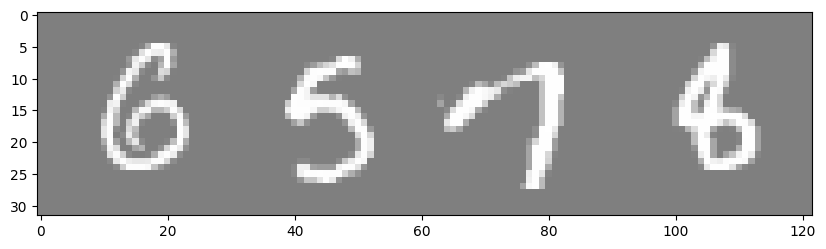

In [ ]:
dataiter = iter(train_loader)
images, label = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))

<br>

<br>

## 신경망 구성

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding='same')
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding='same')
        self.dropout = nn.Dropout2d(0.25)
        # (입력 뉴런, 출력 뉴런)
        self.fc1 = nn.Linear(3136, 1000)    # 7 * 7 * 64 = 3136
        self.fc2 = nn.Linear(1000, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        
        return output

In [ ]:
model = CNN().to(device)

<br>

- `.parameters()` : parameters 확인

In [ ]:
params = list(model.parameters())
print(len(params))
print(params[0].size())

8
torch.Size([32, 1, 3, 3])


<br>

<br>

## 손실함수와 옵티마이저

<br>

#### `nn.CrossEntropy()`

In [ ]:
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

<br>

<br>

## 모델 학습

#### `optimizer.zero_grad` : 가중치의 그래디언트 초기화

<br>

### loss 계산

#### `loss.backward()`

#### `optmizer.step()` : 업데이트

- 배치수 확인

In [ ]:
total_batch = len(train_loader)
print(total_batch)

469


In [ ]:
model.train()

i = 1
for epoch in range(15):

    for data, target in train_loader:

        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0:
            print("Train Step : {}\tLoss : {:3f}".format(i, loss.item()))
        i += 1

Train Step : 1000	Loss : 0.219603
Train Step : 2000	Loss : 0.182396
Train Step : 3000	Loss : 0.101222
Train Step : 4000	Loss : 0.099348
Train Step : 5000	Loss : 0.045623
Train Step : 6000	Loss : 0.089101
Train Step : 7000	Loss : 0.097528


<br>

<br>

## 모델의 저장 및 로드

#### `torch.save`
  - `net.state_dict()`를 저장

In [ ]:
PATH = './mnist_net.pth'

torch.save(model.state_dict(), PATH)


#### `torch.load`
  - `load_state_dict()`로 모델을 로드

In [ ]:
net = CNN()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
net.parameters

<bound method Module.parameters of CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (dropout): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)>

<br>

<br>

## 모델 테스트

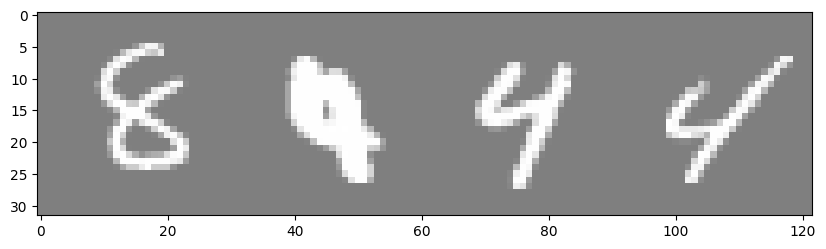

In [ ]:
dataiter = iter(test_loader)

images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([8, 4, 4, 4, 1, 7, 1, 7, 8, 7, 9, 4, 7, 5, 4, 6, 5, 2, 7, 6, 1, 3, 4, 5,
        7, 7, 4, 4, 2, 6, 2, 9, 0, 1, 6, 9, 9, 4, 4, 6, 7, 9, 7, 2, 7, 9, 2, 8,
        2, 1, 6, 2, 1, 9, 0, 9, 0, 4, 6, 7, 7, 0, 6, 8, 1, 7, 5, 6, 9, 1, 3, 0,
        2, 8, 0, 4, 9, 5, 6, 4, 4, 2, 0, 9, 1, 3, 1, 6, 1, 9, 1, 5, 2, 8, 5, 2,
        4, 7, 0, 7, 9, 6, 1, 0, 4, 2, 9, 8, 8, 8, 4, 6, 7, 0, 8, 0, 8, 9, 7, 4,
        1, 7, 9, 3, 1, 6, 4, 9])


In [ ]:
print(''.join('{}\t'.format(str(predicted[j].numpy())) for j in range(4)))

8	4	4	4	


In [ ]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(100 * correct / total)

97.8


<br>

<br>

<br>

# CIFAR10 모델

<br>

<br>

## 전처리 설정

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

<br>

<br>

## 데이터 로드 및 확인

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data',
                                        train=False,
                                        download=True,
                                        transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_loader = DataLoader(trainset, batch_size=4, shuffle=True,num_workers=2)
test_loader = DataLoader(testset, batch_size=4, shuffle=False,num_workers=2)

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

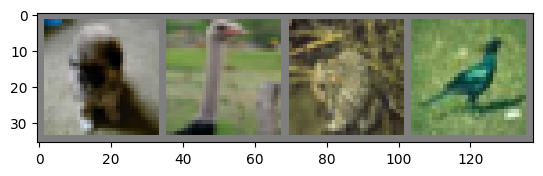

In [ ]:
imshow(torchvision.utils.make_grid(images[:4]))

<br>

<br>

## 신경망 구성

In [ ]:
class Net(nn.Module):
  
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

In [ ]:
net = Net().to(device)

<br>

<br>

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

<br>

<br>

## 모델 학습

<br>

- 설명을 위해 `epochs=2`로 지정

In [ ]:
for epoch in range(2):
  running_loss = 0.0

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
      running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.302117316246033
Epoch: 1, Batch: 4000, Loss: 2.297028683781624
Epoch: 1, Batch: 6000, Loss: 2.28959550344944
Epoch: 1, Batch: 8000, Loss: 2.261625696063042
Epoch: 1, Batch: 10000, Loss: 2.164918598651886
Epoch: 1, Batch: 12000, Loss: 2.0673188877105715
Epoch: 2, Batch: 2000, Loss: 1.968413402080536
Epoch: 2, Batch: 4000, Loss: 1.919231371819973
Epoch: 2, Batch: 6000, Loss: 1.8881915140748025
Epoch: 2, Batch: 8000, Loss: 1.8544122465550898
Epoch: 2, Batch: 10000, Loss: 1.8086897683441638
Epoch: 2, Batch: 12000, Loss: 1.7779394452273847


<br>

<br>

## 모델의 저장 및 로드

In [ ]:
PATH = './cifat_net.pth'
torch.save(net.state_dict(), PATH)

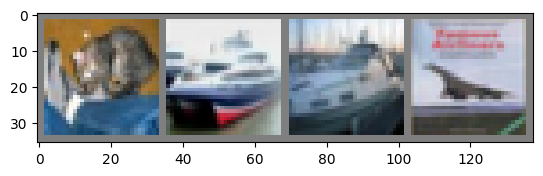

	cat 	ship 	ship 	plane


In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(classes[labels[j]]) for j in range(4)))

In [ ]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

<br>

<br>

## 모델 테스트

In [ ]:
outputs = net(images.to(device))

In [ ]:
_, predicted = torch.max(outputs, 1)
print(' '.join('\t{}'.format(classes[predicted[j]]) for j in range(4)))

	dog 	ship 	ship 	ship


In [ ]:
correct = 0
total = 0

with torch.no_grad():
  
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)

    _, predicte = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(100 * correct / total)

10.26


<br>

- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():

  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)

    _, predicte = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print("Accuracy of {}: {}%".format(classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 0.0%
Accuracy of car: 0.0%
Accuracy of bird: 0.0%
Accuracy of cat: 0.0%
Accuracy of deer: 0.0%
Accuracy of dog: 27.2%
Accuracy of frog: 0.0%
Accuracy of horse: 0.0%
Accuracy of ship: 75.4%
Accuracy of truck: 0.0%
